#### The implementation of a sequential hybrid anomaly detection model using Isolation Forest and SVM begins by loading and cleaning your data. Then, select crucial features and split the data into training and testing sets. Standardize the features to ensure a uniform scale. First, fit an Isolation Forest to isolate potential anomalies quickly, followed by an SVM to refine anomaly detection with a precise classification boundary. Evaluate the model's performance using precision, recall, F1-score, and a confusion matrix to assess accuracy and sensitivity. This method combines the strengths of both models for robust anomaly detection.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import IsolationForest
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import LabelEncoder

C:\Users\sebha\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:112: UserWarning: Features [4] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
C:\Users\sebha\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Precision: 0.963
Recall: 0.963
F1 Score: 0.963
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      3408
           1       0.97      0.98      0.97      7028

    accuracy                           0.96     10436
   macro avg       0.96      0.96      0.96     10436
weighted avg       0.96      0.96      0.96     10436



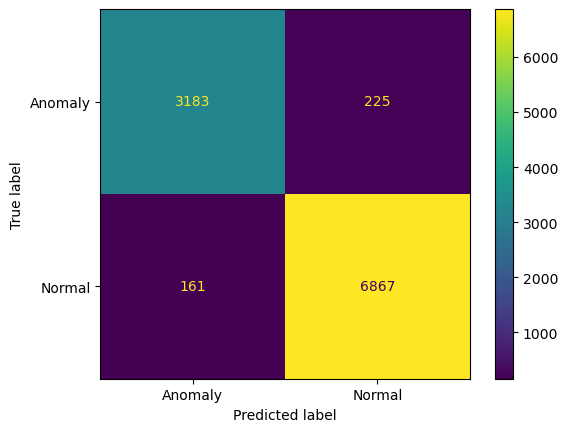

In [2]:

def hybrid_anomaly_detection():
    # Load the dataset
    data = pd.read_csv('US_Util_2020.csv')
    
    #convert all the values in the columns into numeric
    label_encoder = LabelEncoder()
    for column in data.select_dtypes(include=['object']).columns:
        data[column] = label_encoder.fit_transform(data[column])
    
    
    data = data.drop(['zip'], axis=1)
    
#     data.info()
    X = data.drop('res_rate', axis=1)  # Assuming 'target' is the column name of the continuous target variable
    y_cont = data['res_rate']
    
    data = data.dropna(axis=0, inplace=True)

    y = np.where(y_cont > 0.1, 1, 0)  # Define `threshold` based on your domain knowledge
    
    selector = SelectKBest(f_classif, k=4)
    X_selected = selector.fit_transform(X, y)
    
    
    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
        
    # Use Isolation Forest to identify normal data points
    iso_forest = IsolationForest(contamination=0.1, n_estimators=100, random_state=42)
    iso_forest.fit(X_train_scaled)
    iso_preds = iso_forest.predict(X_train_scaled)
    
    # Append Isolation Forest predictions as a new feature to the scaled data
    X_train_scaled_with_pred = np.hstack((X_train_scaled, iso_preds.reshape(-1, 1)))
    
    # Filter only normal data points as identified by Isolation Forest
    normal_indices = np.where(iso_preds == 1)[0]  # Assuming '1' is normal
    X_train_normal = X_train_scaled[normal_indices]
    y_train_normal = y_train[normal_indices]
    
    # Train SVM on the filtered normal data
    svm = SVC(kernel='rbf', gamma='auto')
    svm.fit(X_train_normal, y_train_normal)
    
    # Prepare test data by appending Isolation Forest predictions
    iso_preds_test = iso_forest.predict(X_test_scaled)
    X_test_scaled_with_pred = np.hstack((X_test_scaled, iso_preds_test.reshape(-1, 1)))
    
    # Predict using SVM on the test set
    svm_preds = svm.predict(X_test_scaled_with_pred[:, :-1])  # Exclude the appended Isolation Forest predictions
    
    # Evaluate the final outcome from SVM
    precision = precision_score(y_test, svm_preds, average='weighted', zero_division=0)
    recall = recall_score(y_test, svm_preds, average='weighted', zero_division=0)
    f1 = f1_score(y_test, svm_preds, average='weighted', zero_division=0)
    
    print(f'Precision: {precision:.3f}')
    print(f'Recall: {recall:.3f}')
    print(f'F1 Score: {f1:.3f}')
    
    
    print(classification_report(y_test, svm_preds))
    
    
    # Use a confusion matrix for visualization of the outcome
    
    cm = confusion_matrix(y_test, svm_preds, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Anomaly', 'Normal'])
    disp.plot()
    plt.show()


hybrid_anomaly_detection()